# PHYS 381 - Assignment 4#
### Siegfried Peschke - 30032136
#### March 15, 2019

## Introduction

An iterated function $F(x)$ can be defined by $x_{n} = F(x_{n-1}) = F^n(x_0)$ where $x_0$ is an initial state.

One interesting class of these functions can be written in the form

  $$ z_{i+1} = a \, z^b + c $$
  
where the state vector is a single real ($x$) or complex ($z$) number.  

For this assignment we will focus on the Mandlebrot Set which is a specific case of the class of functions specified where $a = 1$, $b = 2$ and all c values in the complex plane which are bounded when iterated from $z_0 = 0$

$$ z_{i+1} = z^2_i + c $$

A fractal is a geometric pattern that is created by repeating a simple process over and over in an ongoing feedback loop, we will use the Mandlebrot set to generate fractals.

In [1]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt

## Task 1
After "warming-up" with 200 iterations of the Mandlebrot set (starting at $z_0=0$), search for periodic points in the region defined below. In other words, how many points have a limit cycle of $n$ where $n=1,2,3 \ldots 100$?

<pre>
nx, ny = 299,301
xlim=[-0.75, -0.4] ;  ylim=[0.45, 0.8]
x = np.linspace( xlim[0], xlim[1], nx )
y = np.linspace( ylim[0], ylim[1], ny )
xx, yy = np.meshgrid( x, y )
c = xx + yy*1j 
z = 0.0 + 0.0j
</pre>

First we shall import two functions 'mandlebrot_set_count' and 'show_mandlebrot_set' from the class notes 8a. We will modify the function 'mandlebrot_set_count' so that it doesn't continue to calculate on divergent points and call it 'mandlebrot_set_count_nondiv'.

In [2]:
def mandlebrot_set_count(cgrid, maxloops = 999):
    """
    Function from class notes 8a. Author: Brian Jackel
    """
    nx, ny = cgrid.shape
    z = np.zeros( [nx,ny], dtype=np.complex )
    nloops = np.zeros( [nx,ny], dtype=np.int16 )
    
    for i in range(maxloops):
        z = z**2 + cgrid
        nloops[ np.abs(z) < 2 ] = i
        
    return nloops

def mandlebrot_set_count_nondiv(cgrid, maxloops = 999):
    """
    Modified function from class notes which doesn't continue to calculate on divergent points.
    """
    nx, ny = cgrid.shape
    z = np.zeros( [nx,ny], dtype=np.complex )
    nloops = np.zeros( [nx,ny], dtype=np.int16 )
    
    for i in range(maxloops):
        nondiv = np.abs(z) < 2.0
        div = np.abs(z) >= 2.0
        z[nondiv] = z[nondiv]**2 + cgrid[nondiv]
        nloops[nondiv] = i
        
    return nloops, nloops[nondiv], nloops[div]

def show_mandlebrot_set(nx, ny, xlim, ylim, maxloops, plot=False, nondiv=True):
    """
    Function from class notes 8a, modified to include 'mandlebrot_set_count_nondiv'.
    Author: Brian Jackel
    """
    x = np.linspace( xlim[0], xlim[1], nx )
    y = np.linspace( ylim[0], ylim[1], ny )
    xx, yy = np.meshgrid( x, y )
    c = xx + yy*1j
    if nondiv == True:
        countgrid = mandlebrot_set_count_nondiv(c, maxloops)
    else:
        countgrid = mandlebrot_set_count(c, maxloops)

    if plot:
        corners = ( np.min(xx), np.max(xx), np.min(yy), np.max(yy) )
        plt.figure( figsize=(6,6) )
        plt.imshow( countgrid, extent=corners)
        plt.set_cmap('prism')
        
    return countgrid

First we will determine the percentage of points that do not diverge through the course of the first 100 iterations. The 'show_mandlebrot_set' functions return shte number of iterations that a point "survive" without diverging. We can then plot the set that diverges after a particular number of iterations over the course of 100 iterations to visualize at what iterations points diverge.

Number of initial points: 89999
Number of divergent points: 74307
Percentage of divergent points: 82.56%
Number of non-divergent points: 15692
Percentage of non-divergent points: 17.44%


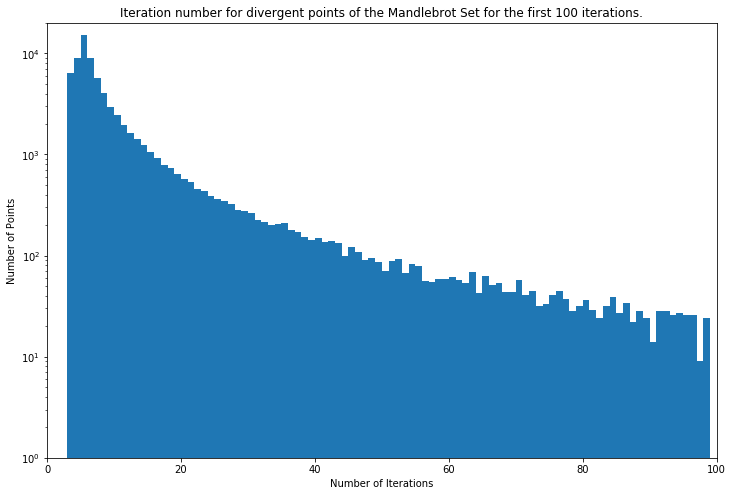

In [3]:
#Grid
plt.figure(figsize=(12,8))
plt.yscale('log')
plt.axis([0, 100, 1, 20000])
#Labels
plt.xlabel('Number of Iterations')
plt.ylabel('Number of Points')
plt.title("Iteration number for divergent points of the Mandlebrot Set for the first 100 iterations.")

#Initial Conditions
max_iter = 100
nx, ny = 299, 301
xlim=[-0.75, -0.4] ;  ylim=[0.45, 0.8]

#Use show_mandlebrot_set to obtain divergent/non divergent sets.
counts, non_div_set, div_set = show_mandlebrot_set(nx, ny, xlim, ylim, max_iter)

#Create the plot
bins = np.arange(0, max_iter + 1, 1)
plt.hist(div_set, bins)

#Calculate some data
total_points = nx*ny
percent_div = len(div_set)/total_points * 100
percent_non_div = len(non_div_set)/total_points * 100
print('Number of initial points: ' + str(total_points))
print('Number of divergent points: ' + str(len(div_set)))
print('Percentage of divergent points: %0.2f' %percent_div + '%')
print('Number of non-divergent points: ' + str(len(non_div_set)))
print('Percentage of non-divergent points: %0.2f' %percent_non_div + '%')

plt.show()

Our data analysis tells us 15692 points of the original 89999 have survived the first 100 iterations without diverging. Therefore we expect the number of the points with limit cycles of $n$ where $n = 1,2,3 ... 100$ will be in the range of 15000-16000.

Now we shall create a function to find points that appear to loop back to a reference value.

In [4]:
def mandlebrot_limit_cycle(nx, ny, xlim, ylim, warmup, maxloops, tol=1e-3):
    """
    This function finds the points in the Mandlebrot set which loop or retrun to the same given value.
    
    Parameters:
        nx: Number of x divisions.
        ny: Number of y divisions.
        xlim: The x-limits.
        ylim: The y-limits.
        warmup: Number of iterations performed in order to eliminate random noise in the set.
        maxloops: Number of iterations of the Mandlebrot set to analyze.
        tol: Tolerance for comparing equality
    Returns:
        num_loop_points: The number of points in the Mandlebrot set which loop.
        counts: The amount of looping per loop period, from 1 to maxloops.
        non_zero: An array of size nx*ny such that it has 1 if the point loops, 0 otherwise.
    """
    #Utilize Initial Conditions
    x = np.linspace( xlim[0], xlim[1], nx )
    y = np.linspace( ylim[0], ylim[1], ny )
    xx, yy = np.meshgrid( x, y )
    c = xx + yy*1j    
    z = 0.0 + 0.0j
    
    #Warm up Mandlebrot set
    for i in range(warmup):
        z = z**2 + c
    
    z1 = z
    non_zero = np.zeros([ny, nx], dtype=np.int16) #Mark off points which have been identified as cycling.
    
    #Find the points
    counts = []
    for i in range(1, maxloops+1):
        z = z**2 + c
        compare = np.isclose(z, z1, rtol = tol)
        compare[non_zero == 1] = 0
        non_zero[compare > 0] = 1
        counts.append((i, len(np.nonzero(compare)[0])))
    num_loop_points = len(np.nonzero(non_zero)[0])
    
    return num_loop_points, counts, non_zero

In 'mandlebrot_limit_cycle' we assert that values which return to a given value in a cycle will always do so in the same way, given the discrete nature of the Mandlebrot set as a discrete recurrence relation. Secondly, we 'warmup' the Mandlebrot set to eliminate random elements in the beginning. If this random noise remains in the set, it may disrupt the next value sifficiently enough that the point may not appear as a stable point. The last major detail is the tolerance introduced due to floating point approximation. We use this tolerance since it is impossible to compare a calculated value to it's original input. Adjusting the tolerance may lead to encompassing too many or insufficiently many points. For the magnitudes of the points of the Mandlebrot set (z < 2), 0.001 precision is reasonable.

Now we will obtain how many points there are given initial conditions, how many are in the set, how many are stable, how many are periodic and how many are chaotic (neither stable or periodic).

Total Points: 89999
Total Mandlebrot Points: 15682
Total Stable Points: 4972
Total Periodic Points: 4372
Total Chaotic Points: 6338


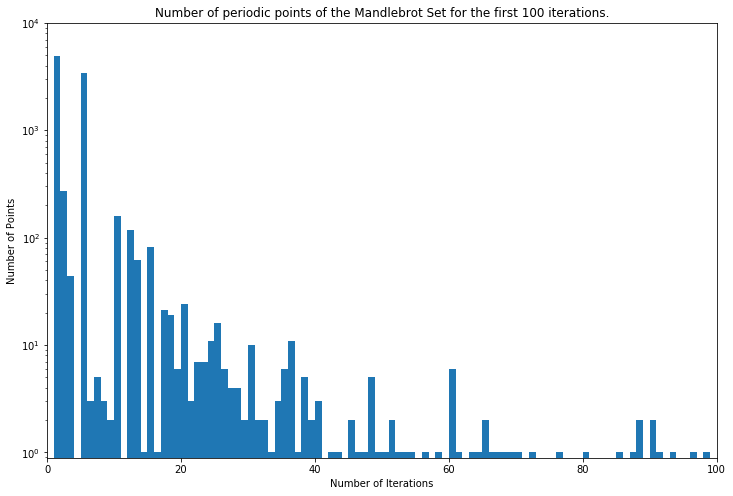

In [5]:
#Hide Error Warnings
import warnings
warnings.filterwarnings("ignore")

#Find the number of points in the grid that are in the Mandlebrot set.
mandlebrot_grid = show_mandlebrot_set(nx, ny, xlim, ylim, max_iter, nondiv = False)
non_zero = np.zeros([ny, nx], dtype=np.int16)
non_zero[mandlebrot_grid == 99] = 1

#Find the number of points in the grid that are part of a limit cycle
total_cycling, count_period, array = mandlebrot_limit_cycle(nx, ny, xlim, ylim, 200, max_iter)

#Calculate some data
total_mandlebrot_pts = len(list(np.nonzero(non_zero)[0]))
total_periodic_stable = total_cycling
total_stable = count_period[0][1]
total_periodic = total_periodic_stable - total_stable
total_chaotic = total_mandlebrot_pts - total_periodic_stable
print('Total Points: ' + str(total_points))
print('Total Mandlebrot Points: %.d' %total_mandlebrot_pts)
print('Total Stable Points: %.d' %total_stable)
print('Total Periodic Points: %.d' %total_periodic)
print('Total Chaotic Points: %.d' %total_chaotic)

#Grid
plt.figure(figsize=(12,8))
plt.yscale('log')
plt.axis([0, 100, 0, 10000])
#Labels
plt.xlabel('Number of Iterations')
plt.ylabel('Number of Points')
plt.title("Number of periodic points of the Mandlebrot Set for the first 100 iterations.")

#Create the plot
results = []
for entry in count_period:
    for i in range(entry[1]):
        results.append(entry[0])
plt.hist(results, bins)

plt.show()

From the plot we can deduce that n = 1 and n = 5 hold the majority of periodic points. From the data calculated, we see that the majority of points are not in the Mandlebrot set and of those that are, the majority are chaotic. Stable and periodic points only make up 36% of the points in the set. This indicates that most points in the Mandlebrot set are there without having any clear pattern.

## Task 2



In [6]:
#Import packages in order to save to JPEG
from PIL import Image
from io import BytesIO

def mandlebrot_fractal(b, n, nx, ny, xlim, ylim, z0):
    """
    This function produces a fractal image for the Mandlebrot set and saves it to the current directory.
    
    Parameters:
        b: Specifies the order of the Mandlebrot set.
        n: Number of iterations of the Mandlebrot set to produce a fractal for.
        nx: Number of x divisions.
        ny: Number of y divisions.
        xlim: The x-limits.
        ylim: The y-limits.
        z0: Initial value for z.
    Returns:
        A fractal plot as well as a saved JPEG version to the current directory.
    """
    #Utilize Initial Conditions
    x = np.linspace( xlim[0], xlim[1], nx )
    y = np.linspace( ylim[0], ylim[1], ny )
    xx, yy = np.meshgrid( x, y )
    c = xx + yy*1j    
    z = z0**b + c
    
    #Create Iterated Set
    for i in range(n):
        nondiv = np.abs(z) < 2
        z[nondiv] = z[nondiv]**b + c[nondiv]
    
    #Plot Fractal
    plt.figure(figsize=(10,10))
    plt.title('Fractal Iterated Function of the Form: $z_{n+1}=z_{n}^{b}+c$ where b = ' + str(b))
    plt.imshow(np.abs(z), extent = (np.min(xx), np.max(xx), np.min(yy), np.max(yy)))
    plt.set_cmap('prism')
    plt.axis('off')
    
    #Create JPEG
    f = BytesIO()
    plt.savefig(f, format = 'png')
    im = Image.open(f)
    rgb_im = im.convert('RGB')
    im_name = 'Mandlebrot_Plot_b=' + str(b) + '.jpg'
    rgb_im.save(im_name)

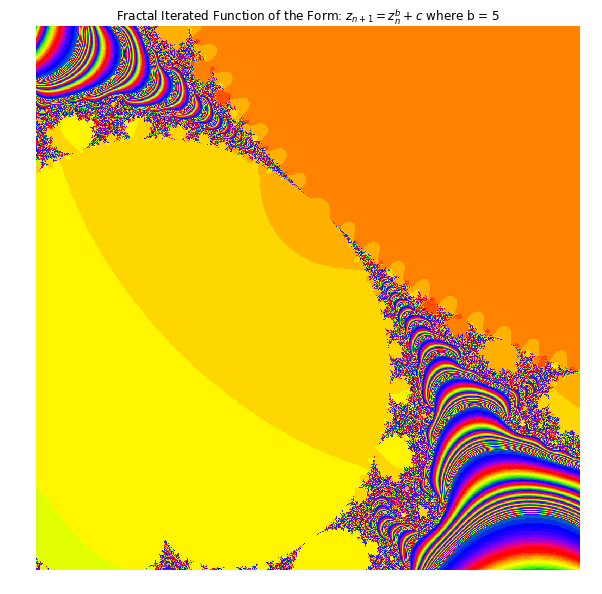

In [7]:
#Initial conditions
b = 5
n = 100
nx, ny = 1000, 1000
xlim=[-0.75, -0.4] ;  ylim=[0.45, 0.8]
z0 = 0 + 0j
mandlebrot_fractal(b, n, nx, ny, xlim, ylim, z0)

## Conclusion

In this assignment we learned that when performing operations on a large set of data, such as the iterated function set, the use of matrix operations makes the calculations much simpler and computationally more cost-effective. Although in theory the matrix operations are simple, implementing these operations into code proved difficult.

The results of the analysis showed that of our initial set, 4% of points resulted in periodic motion. No theory was found for which we could compare the results against. The only expectation we can hold is that the number of periodic points is less than or equal to the number of non-diverging points. Our results are at least consistent with this. It should also be noted that varying the b value for the generated Mandlebrot fractal image produces many pretty pictures!